# Dados de precipitação

Os dados necessários para este notebook podem ser obtidos do link abaixo:

Fonte: <https://portal.inmet.gov.br/dadoshistoricos>

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as pl
import re

import prodes as pr

## Funções

In [2]:
def load_raw_data(filename):
    """
    Load INMET atmospheric data from `filename` (str)
    as a string DataFrame.
    """
    
    df = pd.read_csv(filename, skiprows=8, sep=';', encoding='latin1', low_memory=False, dtype=str)
    # Remove fake columns:
    df = df[df.columns[~df.columns.str.contains('Unnamed')]]
    
    return df

In [3]:
def parse_floats(series, null_strs='-9999'):
    """
    Parse a string `series` into floats, replacing 
    `null_strs` (str or list of str) with NaN.
    """
    if type(null_strs) == str:
        null_strs = [null_strs]
        
    series = series.str.replace('.', '').str.replace(',', '.').copy()
    series.loc[series.isin(null_strs)] = np.NaN
    series = series.astype(float)
    
    return series

In [4]:
def clean_raw_inmet_data(df, null_marker='-9999', non_float_cols=['DATA (YYYY-MM-DD)', 'HORA (UTC)', 'Data', 'Hora UTC']):
    """
    Take a INMET dataset `df` (DataFrame) with string values 
    and parse them into appropriate data types.
    """
    
    # Parse floats:
    float_cols = list(filter(lambda s: s not in non_float_cols, df.columns))
    for col in float_cols:
        df[col] = parse_floats(df[col], null_strs=null_marker)
    
    return df                  

In [5]:
def etl_inmet_data(filename, null_marker='-9999', non_float_cols=['DATA (YYYY-MM-DD)', 'HORA (UTC)', 'Data', 'Hora UTC']):
    """
    Load and prepare INMET atmospheric data.
    Return a DataFrame.
    """
    
    df = load_raw_data(filename)
    df = clean_raw_inmet_data(df, null_marker, non_float_cols)
    
    return df

In [6]:
def filenames_to_ufs(filenames):
    
    df = pd.Series(filenames).str.extract('INMET_[A-Z]{1,2}_([A-Z]{2})')
    df.rename({0:'uf'}, axis=1, inplace=True)
    
    return df

def filename_to_uf(filename):
    return re.search('INMET_[A-Z]{1,2}_([A-Z]{2})', filename).group(1)

In [7]:
def chuva_por_ano_prodes(df, max_nulls=0.3, verbose=False):
    """
    Given a cleaned INMET DataFrame `df`, return a Series
    on total precipitation (mm) per Ano Prodes
    """
    
    # Compute ano prodes:
    for col in set(df.columns) & {'DATA (YYYY-MM-DD)', 'Data'}:
        ano_prodes = pr.date_series_to_ano_prodes(pd.to_datetime(df[col]))
        ano_prodes.name = 'ano_prodes'
        
        
    # Compute the average in each year prodes:
    avg_rain_by_ano_prodes = df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].groupby(ano_prodes).mean()
    avg_rain_df = pd.DataFrame()
    avg_rain_df['ano_prodes'] = ano_prodes
    avg_rain_df = avg_rain_df.join(avg_rain_by_ano_prodes, on='ano_prodes', how='left')

    # Fill missing values with average:
    series = df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].fillna(avg_rain_df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'])
    # Compute total per ano prodes:
    aggregated = series.groupby(ano_prodes).sum()
    
    # If there are too many nulls, ignore the total precipitation (set to NaN):
    agg_nulls  = df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].isnull().groupby(ano_prodes).mean()
    if (agg_nulls > max_nulls).any() and verbose:
        print('Too many nulls:', agg_nulls * 100)
    aggregated.loc[agg_nulls > max_nulls] = np.NaN
    
    return aggregated

In [8]:
def filename_to_rain_df(filename):
    """
    Use data stored in a INMET CSV file to build 
    a dataframe of amount of precipitation (mm) 
    per Ano Prodes (note that only half of Ano Prodes)
    is available in a INMET CSV file.
    """
    
    df = etl_inmet_data(filename)
    uf = filename_to_uf(filename)
    chuva_df = chuva_por_ano_prodes(df).reset_index()
    chuva_df['uf'] = uf
    
    return chuva_df

In [9]:
def inmet_to_rain_ano_prodes_uf(folder):
    """
    Load INMET data for a single year, stored in `folder` 
    (str ending in '/') and compute the average total 
    rain per state and half Ano Prodes.
    
    Returns a DataFrame.
    """
    
    # List files in folder (assumes `folder` ends in '/'):
    filenames = glob(folder + '*.CSV')
    
    # Compute the total rain per ano prodes for each file and concatenate the results:
    # I think each file is a meteorological station.
    df = pd.concat([filename_to_rain_df(f) for f in filenames], ignore_index=True)
    
    # Compute the average rain per UF and half ano prodes: 
    avg_per_uf = df.groupby(['ano_prodes', 'uf']).mean()
    
    return avg_per_uf

In [10]:
def add_semestre(df, ano_civil):
    """
    Create a new column in `df` stating if the row refers to 
    the first or second half of a ano Prodes. For that, use the 
    relation between ano Prodes and ano Civil.
    """
    df['metade_prodes'] = 1 + (df['ano_prodes'] == ano_civil).astype(int)
    return df

## Calculando dados agregados por UF e meio ano Prodes

Esta seção produz os dados para a seção seguinte. Para fazê-lo, descomente as linhas comentadas abaixo.
Esse pré-processamento foi salvo pois ele é demorado.

In [11]:
year = 2020

for year in range(2011, 2022):
    print(year, end=' ')
    folder = '../dados/brutos/clima/{}/'.format(year)
    #df = inmet_to_rain_ano_prodes_uf(folder)
    #df.to_csv('../dados/processed/chuvas/precip_media_por_uf_e_meio_ano_prodes_ano_civil_{}.csv'.format(year))

2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 

## Precipitação anual por estado

Os arquivos de input dessa seção são gerados pela seção anterior.

In [12]:
amz_legal = ['AC', 'AM', 'AP', 'MA', 'MT', 'PA', 'RO', 'RR', 'TO']

In [13]:
# Carrega dados de chuvas por semestre e UF:
file_template = '../dados/processed/chuvas/precip_media_por_uf_e_meio_ano_prodes_ano_civil_{}.csv'
df = pd.concat([add_semestre(pd.read_csv(file_template.format(yr)), yr) for yr in range(2010, 2022)], ignore_index=True)

# Elimina o primeiro e último anos Prodes que estão incompletos:
df = df.loc[(df['ano_prodes'] < df['ano_prodes'].max()) & (df['ano_prodes'] > df['ano_prodes'].min())]

# Calcula a média de precipitação por UF e semestre:
fill_mean = df[['uf', 'metade_prodes']].join(df.groupby(['uf', 'metade_prodes'])['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].mean(), how='left', on=['uf', 'metade_prodes'])['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)']

# Preenche os valores faltantes:
df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].fillna(fill_mean, inplace=True)

In [14]:
# Calcula a quantidade de chuvas por ano prodes e UF:
precip_anual_por_uf = df.groupby(['uf', 'ano_prodes'])['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].sum().reset_index()
precip_amz_por_uf   = precip_anual_por_uf.loc[precip_anual_por_uf['uf'].isin(amz_legal)]

## Agregado na amazônia

In [15]:
# Carrega dados de área florestal dos estados:
prodes = pr.etl_prodes_data('../dados/brutos/desmatamento/prodes/prodes_DesmatamentoMunicipios', 2020, 2020)
area_florestal = prodes.groupby('Estado')['Desmatavel'].sum().sort_values(ascending=False)
area_florestal_total = area_florestal.sum()

In [16]:
# Calcula média da precipitação ponderada pela área florestal de cada estado:
precip_area_amz = precip_amz_por_uf.join(area_florestal, on='uf', how='left')
precip_area_amz['precipitacao_mm'] = precip_area_amz['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'] * precip_area_amz['Desmatavel']
precip_amz_por_ano_prodes = precip_area_amz.groupby('ano_prodes')['precipitacao_mm'].sum() / area_florestal_total

Para exportar os dados processados, descomente a linha abaixo.

In [17]:
# Exporta os dados:
#precip_amz_por_ano_prodes.reset_index().to_csv('../dados/processed/chuvas/precip_amazonica_por_ano_prodes.csv', index=False)

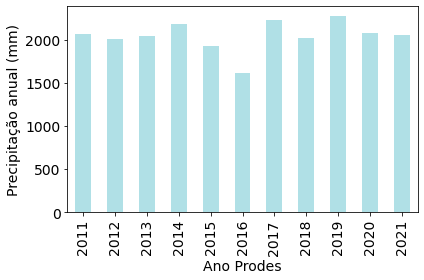

In [22]:
precip_amz_por_ano_prodes.plot(kind='bar', color='powderblue')
pl.tick_params(labelsize=14)
pl.xlabel('Ano Prodes', fontsize=14)
pl.ylabel('Precipitação anual (mm)', fontsize=14)
pl.tight_layout()
#pl.savefig('../resultados/plots/precipitacao_amazonica_por_ano_prodes.png')
pl.show()

## Testes

Testes feitos com os dados, nada muito organizado.

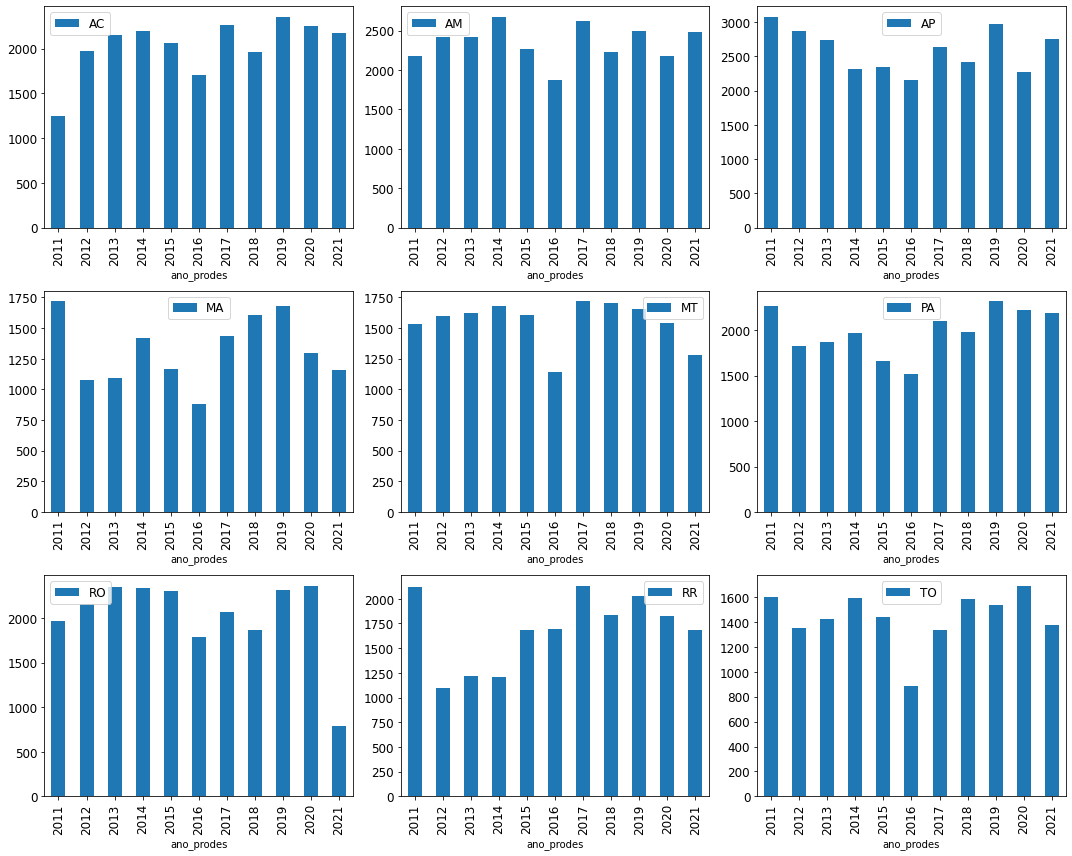

In [64]:
pl.figure(figsize=(15,12))
for i, uf in enumerate(precip_amz_por_uf['uf'].unique()):
    pl.subplot(3,3,i+1)
    precip_amz_por_uf.loc[precip_amz_por_uf['uf'] == uf].set_index('ano_prodes')['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].plot(kind='bar', label=uf)
    pl.legend(fontsize=12)
    pl.tick_params(labelsize=12)
pl.tight_layout()
pl.show()

In [35]:
import utils as xu

In [61]:
yr = 2021
files = glob('../dados/brutos/clima/{}/INMET_N_RO_*.CSV'.format(yr))

i = 3
f = load_raw_data(files[i])
x = etl_inmet_data(files[i])

xu.checkMissing(f)
xu.checkMissing(x)

chuva_por_ano_prodes(x,  verbose=True)

x.loc[pd.to_datetime(x['Data']) <= '{}-07-01'.format(yr), 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].sum()
#x.loc[pd.to_datetime(x['Data']) >= '{}-08-01'.format(yr), 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].sum()

Colunas com valores faltantes:
                                               coluna     N      %
2                    PRECIPITAÇÃO TOTAL, HORÁRIO (mm)  2361  40.48
3   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORAR...  2361  40.48
4     PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)  2391     41
5    PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)  2391     41
6                             RADIACAO GLOBAL (Kj/m²)  3714  63.68
7        TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)  2361  40.48
8                TEMPERATURA DO PONTO DE ORVALHO (°C)  2361  40.48
9          TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)  2391     41
10         TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)  2391     41
11   TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)  2391     41
12   TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)  2391     41
13           UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)  2391     41
14           UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)  2391     41
15                UMIDADE RELAT

994.8

In [131]:
xu.checkMissing(df)

Colunas com valores faltantes:
Empty DataFrame
Columns: [coluna, N, %]
Index: []


In [115]:
df = pd.read_csv('../dados/processed/chuvas/precip_media_por_uf_e_meio_ano_prodes_ano_civil_2015.csv')


,ano_prodes,uf,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"
0,2015,AC,1184.917441
2,2015,AM,1558.967063
3,2015,AP,NaN
9,2015,MA,914.860338
12,2015,MT,910.794303
13,2015,PA,1383.433481
20,2015,RO,1412.066870
21,2015,RR,NaN
26,2015,TO,848.136815
27,2016,AC,728.314712


In [104]:
files = glob('../dados/brutos/clima/2015/INMET_N_AP_*.CSV')
files

['../dados/brutos/clima/2015/INMET_N_AP_A249_MACAPA_01-01-2015_A_31-12-2015.CSV',
 '../dados/brutos/clima/2015/INMET_N_AP_A242_OIAPOQUE_01-01-2015_A_31-12-2015.CSV']

In [106]:
i = 1
t = etl_inmet_data(files[i])
f = load_raw_data(files[i])
chuva_por_ano_prodes(t, verbose=True)

Too many nulls: ano_prodes
2015    71.246069
2016     0.000000
Name: PRECIPITAÇÃO TOTAL, HORÁRIO (mm), dtype: float64


ano_prodes
2015      NaN
2016    441.2
Name: PRECIPITAÇÃO TOTAL, HORÁRIO (mm), dtype: float64

In [111]:
f.loc[t['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].isnull()]

,DATA (YYYY-MM-DD),HORA (UTC),"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)"
521,2015-01-22,17:00,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
744,2015-02-01,00:00,-9999,"1010,9","1010,9","1010,3",-9999,"24,4","22,5","24,7","24,3","22,8","22,5",90,89,90,75,3,",9"
745,2015-02-01,01:00,-9999,"1011,1","1011,1","1010,9",-9999,"23,9","22,2","24,4","23,9","22,6","22,2",90,90,90,76,"2,2",",9"
746,2015-02-01,02:00,-9999,"1011,2","1011,3","1011,1",-9999,24,"22,4","24,1","23,9","22,5","22,2",91,90,91,73,"1,7",",7"
747,2015-02-01,03:00,-9999,"1011,2","1011,3","1011,2",-9999,"23,8","22,4",24,"23,8","22,4","22,2",92,91,92,66,"1,9",",7"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5083,2015-07-31,19:00,-9999,"1009,1","1009,8","1009,1","2291,2","32,1","24,8",33,"31,7","26,2","24,8",70,66,66,94,"5,9","1,7"
5084,2015-07-31,20:00,-9999,"1008,9","1009,1","1008,9","1585,6","31,4","23,9","32,4","31,1","25,1","23,6",66,64,65,92,"5,7","1,9"
5085,2015-07-31,21:00,-9999,"1009,6","1009,6","1008,9","688,4","28,9",22,"31,4","28,9","23,9",22,66,64,66,78,"5,9","1,3"
5086,2015-07-31,22:00,-9999,"1010,1","1010,1","1009,5","47,8",26,"20,7","28,9",26,"21,9","20,5",72,66,72,64,"3,1","1,1"


In [107]:
f.tail()

,DATA (YYYY-MM-DD),HORA (UTC),"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)"
8755,2015-12-31,19:00,"9,4","1009,1","1009,4",1009,"359,6","25,2","24,1",27,"24,7","25,8","23,5",94,92,94,37,"6,4",",9"
8756,2015-12-31,20:00,0,"1009,1","1009,2","1009,1","249,1","25,7","24,6","25,7","25,2","24,6","24,1",94,93,94,65,"2,5",",3"
8757,2015-12-31,21:00,"11,2","1009,9",1010,"1009,1","228,2","24,4","23,4","26,1","24,4",25,"23,3",94,92,94,79,"6,9","2,5"
8758,2015-12-31,22:00,"4,8","1010,9","1010,9","1009,9","6,6",24,"22,9","24,4",24,"23,3","22,9",94,94,94,65,"7,9","2,1"
8759,2015-12-31,23:00,"3,8","1011,8","1011,8","1010,9",-9999,"23,7","22,7",24,"23,6","22,8","22,6",94,94,94,64,"6,8","1,5"
